In [3]:
# THIS REQUIRES PYTHON 3 AND IPYTHON 3
# here's a pip freeze of the necessary packages:
"""
astropy==1.0
ipython==3.0.0
matplotlib==1.4.3
numpy==1.9.2
"""

# delete any old variables as we are, presumably, running the entire notebook.
%reset -f

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rng

from astropy.io import fits
from math import e as E

from collections import namedtuple, deque
from itertools import product
from functools import partial as f
from os.path import isdir

%matplotlib inline

## Conventions
Our main data structure is a Box, which represents a bounding box somewhere in the image.

Our coordinate system has its origin in the bottom-left of the image (with positive up and right), and all coordinates are specified as `(y,x)`. Our box is specified as `(y,x,h,w)`

## Define our boxes.

In [4]:
class Box:
    def __init__(self, y, x, h, w):
        self.pos = (y, x)
        self.size = (h, w)
    
    @property
    def pos(self):
        return self._pos
    @pos.setter
    def pos(self, value):
        assert len(value) == 2
        self._pos = np.array(value, dtype=int)
        
    @property
    def size(self):
        return self._size
    @size.setter
    def size(self, value):
        assert len(value) == 2
        assert all( value[i] > 0 for i in range(len(value)) )
        self._size = np.array(value, dtype=int)

    def __str__(self):
        return '(pos={} sze={})'.format(self.pos , self.size)
    
    def __eq__(self, other):
        return np.all(self.pos == other.pos) and np.all(self.size == other.size)
    
    def _get_integral_image_elt(self, pos, integral_image):
        M, ny, nx = integral_image.shape
        cpos = np.clip(pos, [0, 0], [ny, nx])

        if np.any(pos == 0):
            return np.zeros(M)
        return integral_image[:, cpos[0]-1, cpos[1]-1]
    
    def counts(self, integral_image):
        corners = (self.pos,
                   self.pos + [self.size[0], 0],
                   self.pos + [self.size[0], self.size[1]],
                   self.pos + [0, self.size[1]])
        
        return (self._get_integral_image_elt(corners[0], integral_image)
                - self._get_integral_image_elt(corners[1], integral_image)
                + self._get_integral_image_elt(corners[2], integral_image)
                - self._get_integral_image_elt(corners[3], integral_image))    

## Define helper functions.

In [75]:
from matplotlib.patches import Rectangle
SAVE_DIR = '../output'

# represents loaded data. the truth field may be none.
Data = namedtuple('Data', ['img','truth'])

def as_boxes(*args):
    """
    Turns some parameter triplets into boxes. Handles all of the following:
      as_boxes( [(10,0,10,10), (20,50,10,10)] )
      as_boxes( (10,0,10,10), (20,50,10,10) )
      as_boxes(10,0,10,10)
    """
    if type(args[0]) in [float, int]:
        return [ Box(*args) ]
    elif type(args[0]) == tuple:
        return [ Box(*t) for t in args ]
    elif type(args[0]) == list:
        return [ Box(*t) for t in args[0] ]
    
def show (image, *args, file=None, figsize=(10,10), dpi=500, pad_inches=0):
    """
    Show the given image. The varargs can be used to pass models (ie. lists of boxes) to draw on top
    of the image. This can take two forms:
    
        1. pass in a single dict of the form { 'colour1':model1, 'colour2':model2 }
        2. pass in up to 6 models as individual parameters, and they will be automatically coloured.
    """
    
    plt.figure(figsize=figsize, dpi=dpi)
    COLOURS = ['blue', 'red', 'yellow', 'orange', 'purple', 'green']
    
    plt.gray()
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.imshow(image, interpolation='nearest', origin='lower')
    
    if len(args) > 0 and type(args[0]) == list: # [ model1, model2, ...]
        for colour, model in zip(COLOURS, args):
            for box in model:
                plt.gca().add_patch(Rectangle(tuple(reversed(box.pos)), box.size[1], box.size[0], alpha=0.9, facecolor='None', edgecolor=colour))
    elif len(args) == 1 and type(args[0]) == dict: # { 'red':model1, 'blue':model2 }
        for colour, model in args[0].items():
            for box in model:
                plt.gca().add_patch(Rectangle(tuple(reversed(box.pos)), box.size[1], box.size[0], alpha=0.9, facecolor='None', edgecolor=colour))
            
    if file != None:
        if isdir(SAVE_DIR):
            plt.savefig('{}/{}'.format(SAVE_DIR, file), bbox_inches='tight', pad_inches=pad_inches)
        else:
            print("output directory '{}' does not exist.".format(SAVE_DIR))
        
def fake_data (sources:'[(y, x, h, w, brightness, variance)]'=[], size:'(y, x)'=(1000,1000)):
    img = rng.uniform(size=size)
    boxes = []
    
    # define each source by making a Box, and manipulating the image.
    for (y, x, h, w, b, v) in sources:
        boxes.append( Box(y, x, h, w) )
        img[y:y+h, x:x+w] = np.clip((img[y:y+h, x:x+w] + b) * v, 0, 1)
    
    return Data(img, boxes)

def real_data (filename='frame-r-000094-1-0131.fits.gz'):
    hdulist = fits.open('../data/{}'.format(filename))
    img = hdulist[0].data
    hdulist.close()
    return Data(img, None)

## Integral image
These functions turn a raw image into a discretised integral image suitable for finding histograms with. The main function of interest is `integral_image`, which takes an image and a number of bins and does all the work.

#### Why not equal-occupancy?
Good question. If we discretise our image using equal-occupancy bins, we lose any knowledge of the background distribution. For example, suppose the background strictly follows a uniform distribution, and the image contains a single very bright source. On binning, the top bins will be almost entirely filled with the source leaving little room for the background; this means the discrete version of the background will not follow a uniform distribution over the bins, as it lacks presence in the top ones.

But we do want to maintain information on the distribution of the background, so instead we use equal-range bins. There is probably an improvement on this, for example using manually specified unequal-range bins that suit our images better.

In [76]:
def as_bins(img, M):
    """ 
    Discretises an image into M equal-range bins, the output is an array of the same dimensions.
    Assumes data is in [0,1]?
    """
    
    lo, hi = np.min(img), np.max(img)
    f = np.vectorize(lambda x: (int)(M * (x-lo) / (hi-lo)) if x < hi else M-1, otypes=[np.int])
    return f(img)

def as_booleans(dimg, M):
    """
    Takes a discrete image and a number of blocks, and returns a 3D array. The 2D array at index i contains
    True's at each coordinate where the discrete image contained bin index i. There are M indices, of course.
    """
    
    ny, nx = dimg.shape
    N = ny * nx
    bimg = np.zeros((M, ny, nx),dtype=bool)
    for m in range(M):
        bimg[m, :, :] = (dimg == m)
    return bimg

def as_accumulation(bimg):
    """
    Given a boolean image array, creates the integral image by summing up each 2D array from bottom-left to
    top-right.
    """
    
    return np.cumsum(np.cumsum(bimg, axis=2), axis=1)

def integral_image(img, M): 
    return as_accumulation(as_booleans(as_bins(img, M), M))

## The algorithm

This assumes the background distribution is uniform, because it's easy to work with. Hence the cdf for bin index $i$ of $M$ is simply $\frac{i+1}{M}$ (indices start at 0). I'm taking the critical values for the K-S test from here: http://www.mathematik.uni-kl.de/~schwaar/Exercises/Tabellen/table_kolmogorov.pdf.

I'm assuming that $n > 35$ here, because we set the `min_area` to 1000 (hence at least 1000 samples). This might be the next thing to work on, what's a better solution than just making a straight cut-off for size? There's got to be a point at which we're just never convinced that a box of that size can contain enough evidence for a source. Maybe the K-S test gives us that, we just stick with one-box-up when the K-S test fails.

A summary of that last paragraph: right now, I'm evaluating a box as follows:
 - split it up and put its children boxes on the queue
 - throw the original box away forever, no matter what.
 
This is a bit dim, really, because if a source gets split into boxes too small to provide enough evidence, it gets thrown away. Instead, I should probably keep the original box around if none of the children boxes are evaluated as saucy. This could end up making quite a cool tree-structure to navigate through (which I think we talked about a while ago Marcus). More experiments to be done.

In [77]:
def fast(iimg, min_area=1000):
    M, h, w = iimg.shape
    
    def is_odd(box):
        counts, area = box.counts(iimg), box.size[0] * box.size[1]
                
        accumulation = [sum(counts[:i+1])/area for i in range(M)]
        # print(accumulation)
        expectation  = [(i+1) / M for i in range(M)]
        # print(expectation)
        max_diff = max(abs(accumulation[i] - expectation[i]) for i in range(M))
        
        critical_value = 1.224/np.sqrt(area)
        #print('md:', max_diff, 'cv:', critical_value)
        
        return max_diff > critical_value

    count = 0
    inactive, result = [], []
    active = deque([ Box(0,0,h,w) ])
    
    while len(active) > 0:  
        box = active.popleft()
        
        if box.size[0]*box.size[1] <= min_area:
            result.append(box)
            continue
        
        sub_boxes = [ Box(box.pos[0] + dy*box.size[0]/2, box.pos[1] + dx*box.size[1]/2, box.size[0]/2, box.size[1]/2)
                      for dy in range(2) for dx in range(2) ]
        sub_boxes = [ t for t in sub_boxes if is_odd(t) ]
        
        count += 4
        if len(sub_boxes) == 0:
            inactive.append(box)

        active.extend(sub_boxes)

    print('evaluations: {}'.format(count))
    return result

## Testing fake data

evaluations: 312


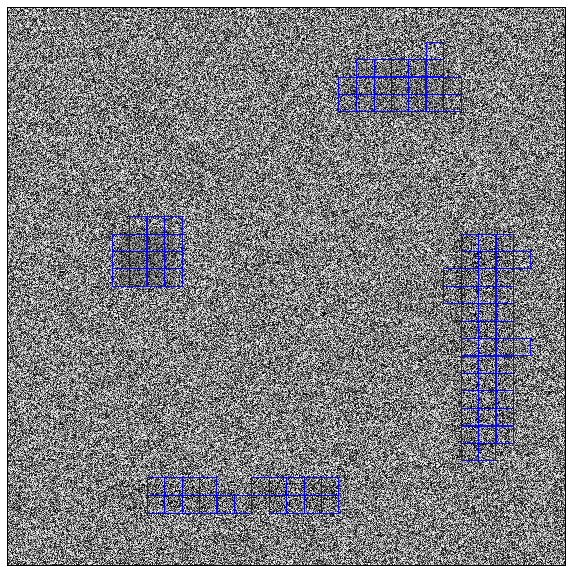

In [78]:
BINS = 32

sources = [(100,200,50,400,-0.05,1), (200,800,400,100,-0.05,1), (800,600,100,200,0,0.9), (500,200,100,100,0,0.8)]

img, truth = fake_data(sources)
iimg = integral_image(img, BINS)

result = fast(iimg)
show(img, result, file='fake_{}_bins.png'.format(BINS))

## A few experiments
Let's make some fake data that's a little bit off, put boxes around it, and see the result of the K-S test on those boxes.

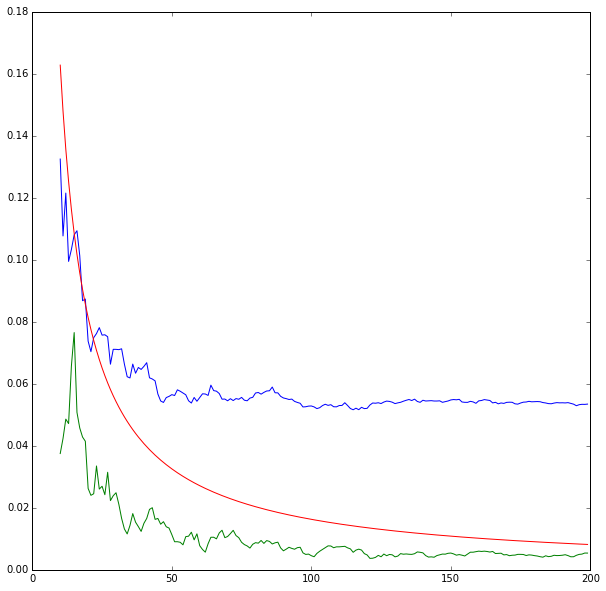

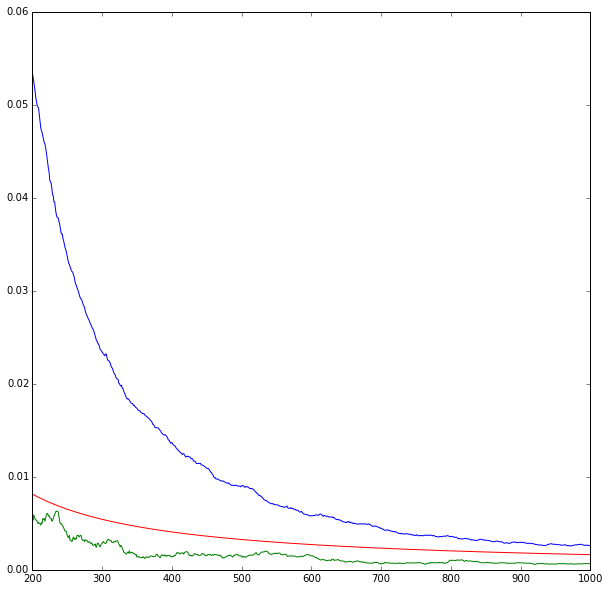

In [106]:
BINS = M = 32
CV = 1.628 # the critical value for 99% confidence.

sources = [(0,0,200,200,0.05,1)]
img1, _ = fake_data(sources)
iimg1 = integral_image(img1, BINS)

img2, _ = fake_data([])
iimg2 = integral_image(img2, BINS)

def ks_test(box, iimg):
    counts, area = box.counts(iimg), box.size[0] * box.size[1]

    accumulation = [sum(counts[:i+1])/area for i in range(M)]
    # print(accumulation)
    expectation  = [(i+1) / M for i in range(M)]
    # print(expectation)
    return max(abs(accumulation[i] - expectation[i]) for i in range(M))

# GRAPH NUMBER 1 - small square sizes
square_sizes = range(10,200)

ks_results_1 = [ks_test(Box(0,0,s,s), iimg1) for s in square_sizes]
ks_results_2 = [ks_test(Box(0,0,s,s), iimg2) for s in square_sizes]
critical_values = [CV / np.sqrt(s*s) for s in square_sizes]

plt.figure(figsize=(10,10), dpi=500)
plt.plot(square_sizes, ks_results_1) 
plt.plot(square_sizes, ks_results_2) 
plt.plot(square_sizes, critical_values)

# GRAPH NUMBER 2 - big square sizes
square_sizes = range(200,1000)

ks_results_1 = [ks_test(Box(0,0,s,s), iimg1) for s in square_sizes]
ks_results_2 = [ks_test(Box(0,0,s,s), iimg2) for s in square_sizes]
critical_values = [CV / np.sqrt(s*s) for s in square_sizes]

plt.figure(figsize=(10,10), dpi=500)
plt.plot(square_sizes, ks_results_1) 
plt.plot(square_sizes, ks_results_2) 
plt.plot(square_sizes, critical_values)

## So what's this showing?

First, we make two images. The first has a 200 by 200 source in the bottom-left corner and the second is purely background.

For each graph, the x-axis is the size of a square starting in the bottom-left corner, and the y-axis is the value of the K-S test. Each graph plots:
 - BLUE: the value of a K-S test with a square size = x-value on the source-containing image.
 - GREEN: the value of a K-S test on an all-background image.
 - RED: the threshold value for the K-S test at 99% confidence, i.e. $\frac{1.628}{\sqrt{\text{size}}}$
 
So there are two things we care about here, the first is that we don't miss the source when looking at really large boxes, and the second is that we continue to exclude the background when looking at really small boxes. Both plots neatly divide the background line from the source line with the threshold.

#SMASHING.

PS. The fact that the red line grows a bit fast for small box sizes isn't surprising, since you're supposed to use different critical values for small samples sizes (below about 40).